#  Прогнозирование количества заказов такси

Для таксомоторной компании необходимо спрогнозировать количество заказов с целью поддержания необходимого количества водителей на линии. 

Период прогнозирования один час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.



<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Позведем-анализ-данных-на-отрезке-в-пол-года-(период-всей-предоставленной-выборки)." data-toc-modified-id="Позведем-анализ-данных-на-отрезке-в-пол-года-(период-всей-предоставленной-выборки).-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Позведем анализ данных на отрезке в пол года (период всей предоставленной выборки).</a></span></li><li><span><a href="#Внутридневной-анализ-с-ресемплированием-в-1-час." data-toc-modified-id="Внутридневной-анализ-с-ресемплированием-в-1-час.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Внутридневной анализ с ресемплированием в 1 час.</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-случайного-леса-регрессии" data-toc-modified-id="Модель-случайного-леса-регрессии-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель случайного леса регрессии</a></span></li><li><span><a href="#Модель-LightGBM" data-toc-modified-id="Модель-LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель LightGBM</a></span></li><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Модель CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Получение-результатов-на-тестовой-выборке" data-toc-modified-id="Получение-результатов-на-тестовой-выборке-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Получение результатов на тестовой выборке</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Использование-GreadSearchCV-и-метода-TimeSeriesSplit-для-временных-рядов-на-примере-модели-LGBM" data-toc-modified-id="Использование-GreadSearchCV-и-метода-TimeSeriesSplit-для-временных-рядов-на-примере-модели-LGBM-4.1.0.1"><span class="toc-item-num">4.1.0.1&nbsp;&nbsp;</span>Использование GreadSearchCV и метода TimeSeriesSplit для временных рядов на примере модели LGBM</a></span></li></ul></li></ul></li><li><span><a href="#Графическое-сравнение" data-toc-modified-id="Графическое-сравнение-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Графическое сравнение</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Подготовка данных

In [1]:
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import math

In [2]:
path = 'C:/users/v_kly'

In [3]:
df = pd.read_csv(path + '/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим в хронологическом ли порядке расположены дата и время.

In [6]:
df.index.is_monotonic

True

Метод `is_monotonic` сигнализирует о том, что данные расположены в хронологическом порядке.

Произведем ресемплирование выборки по 1 часу. 

In [7]:
df = df.resample('1H').sum()

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Ресемплирование произведено корректно, теперь у нас есть данные по количеству заказов за каждый час.

## Анализ

###  Позведем анализ данных на отрезке в пол года (период всей предоставленной выборки).

Сделаем ресемплирование по одному дню.

In [9]:
df_day_sum = df.resample('1D').sum()

In [10]:
df_day_sum['rolling_mean'] = df_day_sum.rolling(10).mean()

<AxesSubplot:xlabel='datetime'>

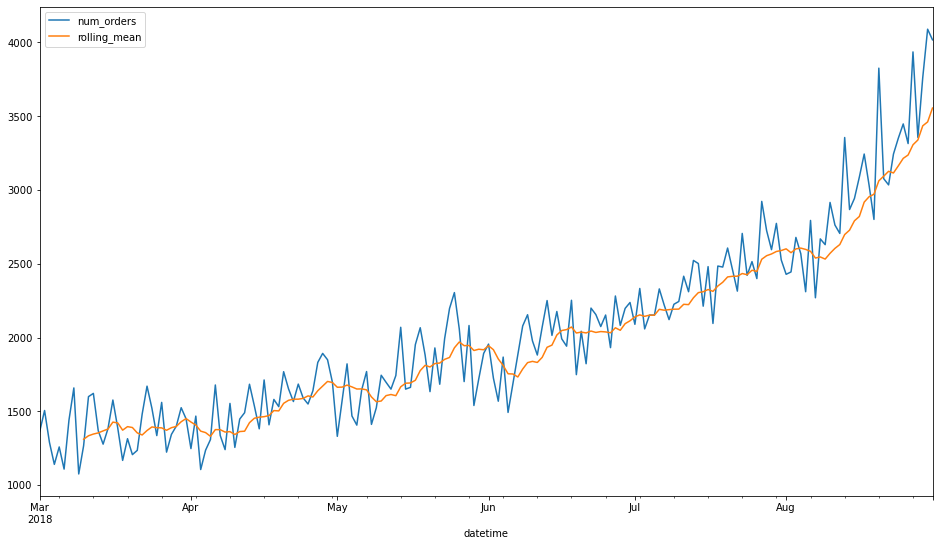

In [11]:
df_day_sum.plot(figsize=(16,9))

На графике выше прослеживается возрастающий тренд по количеству заказов такси с марта по конец августа.

Произведем разложение на трендовую, сезонную и шумовую компоненты. Немного увеличим масштаб и посмотрим на разложение в рамках одного месяца.

In [12]:
decomposed_day = seasonal_decompose(df_day_sum['num_orders']['2018-03-01':'2018-04-01'])

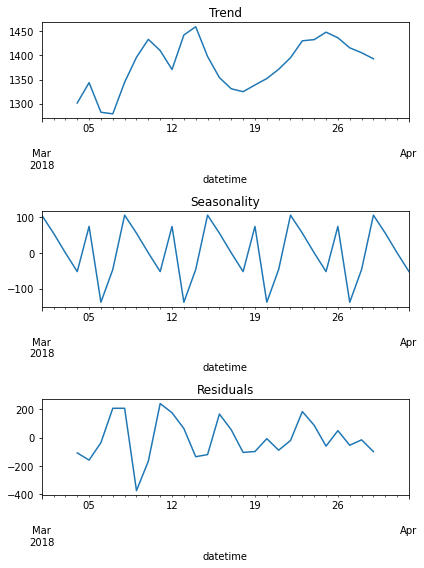

In [13]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed_day.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_day.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По графикам выше мы видим, что присутствует сезонность в недельных периодах: ко вторнику идет спад по количеству заказов, и после к четвергу набирается пиковый объем.

### Внутридневной анализ с ресемплированием в 1 час.

Посмотрим на дневные периоды с часовым ресемплированием.

In [14]:
decomposed_hour = seasonal_decompose(df['2018-03-01':'2018-03-02'])

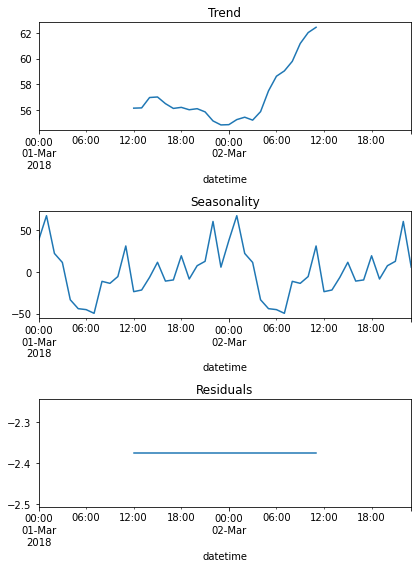

In [15]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed_hour.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_hour.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_hour.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По графику сезонности выше видно, что количество заказов такси набирает пиковые значения к часу ночи,  и с этого момента до 7 утра идёт спад, а далее постепенный рост до пиковых значений к концу дня.

**Вывод:** Проведя анализ временного ряда объемов заказов такси был выявлен основной восходящий тренд на периоде в 6 месяцев с марта по конец августа, а также недельная и внутредневная сезонность по объёмам заказов. Так как у нас срез данных всего 6 месяцев, сложно сделать вывод, является ли этот тренд абсолютным ростом заказов такси или сезонностью на большем масштабе.

## Обучение

### Создание признаков

Создаем функцию, включающую в себя создание признаков по дате, временному сдвигу признака для использования исторических значений и скользящего среднего.

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
   
    data['rolling_mean4'] = data['lag_1'].rolling(24).mean()
    
    data.dropna(inplace=True)

In [17]:
make_features(df, 1, 3)
df.head()

,num_orders,dayofweek,hour,lag_1,rolling_mean4
datetime,,,,,
2018-03-02 00:00:00,90,4,0,58.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,55.416667
2018-03-02 02:00:00,75,4,2,120.0,56.875000
2018-03-02 03:00:00,64,4,3,75.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,56.958333


Разделим данные на обучающую, валидационную и тестовую выборки. 

In [18]:
train, valid_test = train_test_split(df, shuffle=False, test_size=0.4)

valid, test = train_test_split(valid_test, shuffle=False, test_size=0.25)

print(train.shape)
print(valid.shape)
print(test.shape)

(2635, 5)
(1317, 5)
(440, 5)


Отделим признаки о целевых значений.

In [19]:
train_features = train.drop('num_orders', axis=1)
valid_features = valid.drop('num_orders', axis=1)
test_features = test.drop('num_orders', axis=1)

train_target = train['num_orders']
valid_target = valid['num_orders']
test_target = test['num_orders']

### Модель линейной регрессии

Обучим модель линейной регрессии и посчитаем метрику RMSE.

In [20]:
%%time
model_lin = LinearRegression()

model_lin.fit(train_features, train_target)

pred_lin = model_lin.predict(valid_features)

rmse_lin_valid = mean_squared_error(valid_target, pred_lin)**0.5

print('RMSE Линейной регрессии на валидационной выборке:', rmse_lin_valid)
print()

RMSE Линейной регрессии на валидационной выборке: 36.583179358343

Wall time: 20 ms


### Модель случайного леса регрессии

Обучим модели случайного леса регрессии, посчитаем метрику RMSE и определим лучшие параметры.

In [21]:
# формирования списка моделей с разными гиперпараметрами
def get_models_rfr():
    models = []
    for n in range(10, 100, 10):
        for i in range(2, 20, 3):
            models.append(RandomForestRegressor(n_estimators=n, max_depth = i))
    return models

In [22]:
%%time
models = get_models_rfr()
best_model_rfr = []
best_rmse = 10000
best_total_time = 0
for i in tqdm(models):
    startTime = time.time() 
    i.fit(train_features, train_target)
    endTime = time.time()
    totalTime = endTime - startTime 
    pred = i.predict(valid_features)
    rmse = mean_squared_error(valid_target, pred)**0.5
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_rfr = i
        best_total_time = totalTime
        
print('Время обучения лучшей модели:', round(best_total_time), 'сек.')
print('RMSE модели', best_rmse)
print('Лучшая модель:', best_model_rfr)


Время обучения лучшей модели: 0 сек.
RMSE модели 30.648610282426823
Лучшая модель: RandomForestRegressor(max_depth=14, n_estimators=70)
Wall time: 9.29 s


Модель с лучшей метрикой ``RMSE равной 30.56`` имеет параметры `max_depth=14` и `n_estimators=30`

### Модель LightGBM

In [23]:
# формирования списка моделей с разными гиперпараметрами
def get_models_lgbm():
    models = []
    trees = [10, 50, 100, 500, 1000]
    for n in trees:
        models.append(LGBMRegressor(n_estimators=n))
    return models

In [24]:
%%time
models = get_models_lgbm()
for i in tqdm(models):
    startTime = time.time() 
    i.fit(train_features, train_target)
    endTime = time.time()
    totalTime = endTime - startTime 
    pred = i.predict(valid_features)
    rmse = mean_squared_error(valid_target, pred)**0.5
    print('Время обучения модели:', round(totalTime), 'сек.')
    print('RMSE модели', rmse)
    print()

Время обучения модели: 0 сек.
RMSE модели 38.261742534748805

Время обучения модели: 0 сек.
RMSE модели 31.917702503760825

Время обучения модели: 0 сек.
RMSE модели 32.11256031586448

Время обучения модели: 0 сек.
RMSE модели 33.14044484116191

Время обучения модели: 1 сек.
RMSE модели 33.6182608640692


Wall time: 945 ms


Модель LGBM с лучшей метрикой ``RMSE равной 31.92`` имеет параметр ``n_estimators=50``

### Модель CatBoost

Подберем параметры для модели CatBoost

In [25]:
%%time
cat = CatBoostRegressor(verbose=0)
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6]
        }

grid_search_result = cat.grid_search(grid, X=train_features, y=train_target, verbose=0)



bestTest = 20.22356083
bestIteration = 999


bestTest = 20.21146065
bestIteration = 426


bestTest = 20.10427259
bestIteration = 794


bestTest = 20.17895449
bestIteration = 216

Wall time: 9.84 s


Подобранные параметры: `{'depth': 6, 'learning_rate': 0.03}`

Обучим модель с подобранными гиперпараметрами и посчитаем RMSE

In [26]:
cat_003_6 = CatBoostRegressor(learning_rate=0.03 , depth=6)

In [27]:
%%time
cat_003_6.fit(train_features, train_target, verbose=0)

Wall time: 1.57 s


In [28]:
predictions_cat = cat_003_6.predict(valid_features)

In [29]:
rmse_cat = mean_squared_error(valid_target, predictions_cat)**0.5
print('RMSE модели CatBoost', rmse_cat)

RMSE модели CatBoost 31.925578587664898


**Вывод:** Значение метрики RMSE полученные на валидационной выборке у обученных моделей имеет разброс от 30.56 до 36.58. Итоговое сравнение проведем ниже, после оценки на тестовой выборке.

## Тестирование

Для сохранения целостности временного ряда при проведении моделировании на тестовой выборке соединим тренировочную и валидационную выборки.

In [30]:
print('Валидационная выборка признаков:', valid_features.shape)

print('Тренировочная выборка признаков:', train_features.shape)

features_join = pd.concat([train_features, valid_features], sort=False, axis=0)

print('Объединенная выборка признаков:', features_join.shape)

Валидационная выборка признаков: (1317, 4)
Тренировочная выборка признаков: (2635, 4)
Объединенная выборка признаков: (3952, 4)


In [31]:
print('Валидационная выборка признаков:', valid_target.shape)

print('Тренировочная выборка признаков:', train_target.shape)

target_join = pd.concat([train_target, valid_target], sort=False, axis=0)

print('Объединенная выборка признаков:', target_join.shape)

Валидационная выборка признаков: (1317,)
Тренировочная выборка признаков: (2635,)
Объединенная выборка признаков: (3952,)


### Получение результатов на тестовой выборке

Используем обученные выше модели с подобранными параметрами, показавшие наилучший результат, для предсказания на тестовой выборке.

**Модель Линейной Регрессии**

In [32]:
%%time
model_lin.fit(features_join, target_join)
pred_lin_test = model_lin.predict(test_features)

rmse_lin_test = mean_squared_error(test_target, pred_lin_test)**0.5

print('RMSE Линейной регрессии на тестовой выборке:', rmse_lin_test)
print()

RMSE Линейной регрессии на тестовой выборке: 51.22000101433688

Wall time: 6 ms


**Модель Случайного Леса Регрессии**

In [33]:
%%time
model_rfr_test = RandomForestRegressor(n_estimators=30, max_depth = 14)
model_rfr_test.fit(features_join, target_join)

Wall time: 204 ms


RandomForestRegressor(max_depth=14, n_estimators=30)

In [34]:
%%time
pred_rfr_test = model_rfr_test.predict(test_features)
rmse_rfr_test = mean_squared_error(test_target, pred_rfr_test)**0.5

print('RMSE Случайного Леса Регрессии на тестовой выборке:', rmse_rfr_test)
print()

RMSE Случайного Леса Регрессии на тестовой выборке: 46.43729112093378

Wall time: 6.11 ms


**Модель LightGBM**

In [35]:
%%time
model_lgbm_test= LGBMRegressor(n_estimators=50)
model_lgbm_test.fit(features_join, target_join)

Wall time: 34 ms


LGBMRegressor(n_estimators=50)

In [36]:
%%time
pred_lgbm_test = model_lgbm_test.predict(test_features)
rmse_lgbm_test = mean_squared_error(test_target, pred_lgbm_test)**0.5

print('RMSE LGBM на тестовой выборке:', rmse_lgbm_test)
print()

RMSE LGBM на тестовой выборке: 44.16311917145683

Wall time: 3 ms


##### Использование GreadSearchCV и метода TimeSeriesSplit для временных рядов на примере модели LGBM

Произведем перебор параметров для модели LGBM с использованием ``GreadSearchCV`` и метода ``TimeSeriesSplit``

In [37]:
lgbm = LGBMRegressor()
tscv = TimeSeriesSplit(n_splits=8)
param_set = {'learning_rate' : [0.02, 0.1, 0.5], 'n_estimators' : [50, 100, 200], 'max_depth' : [-1, 5, 10, 20]}

gsearch = GridSearchCV(lgbm, param_grid=param_set, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=0) 

In [38]:
%%time 
gsearch.fit(features_join, target_join)

Wall time: 5.28 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.02, 0.1, 0.5],
                         'max_depth': [-1, 5, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [39]:
gsearch.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

In [40]:
math.sqrt(-gsearch.best_score_)

24.687766078716827

Обучим модель LGBM с использованием подобранных параметров и посчитаем предсказания и целевую метрику RMSE на тестовой выборке.

In [41]:
%%time
lgbm_test = LGBMRegressor(learning_rate=0.1, max_depth=5, n_estimators=100)
lgbm_test.fit(features_join, target_join)

pred_lgbm_test_cv = lgbm_test.predict(test_features)
rmse_lgbm_test = mean_squared_error(test_target, pred_lgbm_test_cv)**0.5

print('RMSE LGBM на тестовой выборке:', rmse_lgbm_test)
print()

RMSE LGBM на тестовой выборке: 42.69679408594258

Wall time: 43 ms


**Модель CatBoost**

In [42]:
cat_003_6 = CatBoostRegressor(learning_rate=0.03 , depth=6)

In [43]:
%%time
cat_003_6.fit(features_join, target_join, verbose=0)

Wall time: 1.69 s


In [44]:
pred_cat_test = cat_003_6.predict(test_features)

In [45]:
rmse_cat = mean_squared_error(test_target, pred_cat_test)**0.5
print('RMSE модели CatBoost', rmse_cat)

RMSE модели CatBoost 42.55476197535738


In [46]:
index = [
    ['LinearRegression', 51.22],
    ['RandomForestRegression', 45.95],
    ['LightGBM', 44.16],
    ['CatBoost', 42.11]
]
col_cat = ['Модель', 'RMSE']
research_models_cat = pd.DataFrame(index, columns=col_cat)
print('\n', 'Таблица сравнения итоговых метрик для разных моделей', '\n')
display(research_models_cat)


 Таблица сравнения итоговых метрик для разных моделей 



,Модель,RMSE
0,LinearRegression,51.22
1,RandomForestRegression,45.95
2,LightGBM,44.16
3,CatBoost,42.11


### Графическое сравнение 

Напишем функцию вывода графика целевых значений и предсказаний модели.

In [47]:
def comparison(pred, target, start, stop, title_model):
    predictions = pd.Series(pred, index=target.index) 
    predictions[start:stop].plot(figsize=(16,9), label='Предсказания')
    target[start:stop].plot(figsize=(16,9), label='Фактические значения')
    plt.legend()
    plt.xlabel('Дата/Время')
    plt.ylabel('Количество заказов')
    plt.grid(True)
    plt.title(title_model)

Построим для результатов каждой модели сравнительные графики.

**Линейная регрессия**

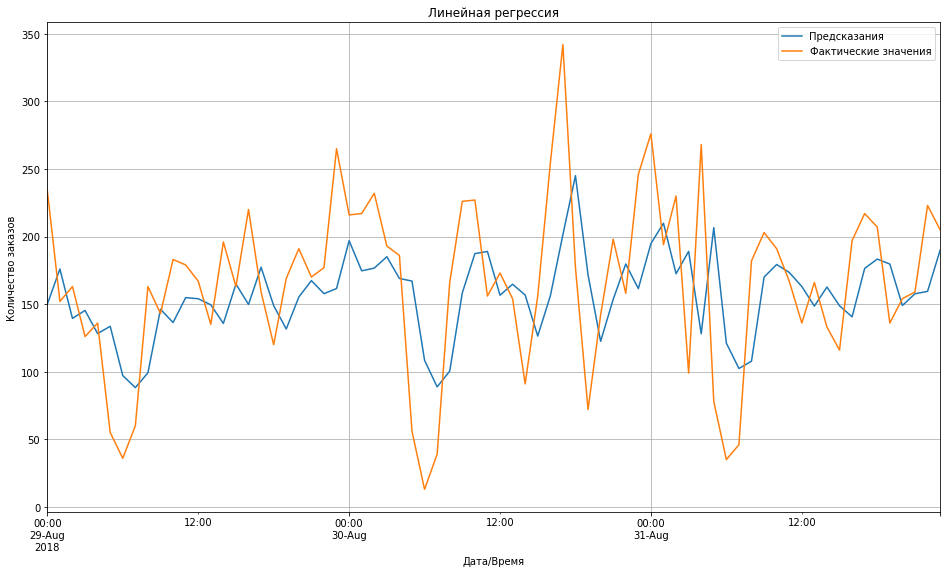

In [48]:
comparison(pred_lin_test, test_target, '2018-08-29','2018-08-31', "Линейная регрессия")

**Случайный Лес Регрессии**

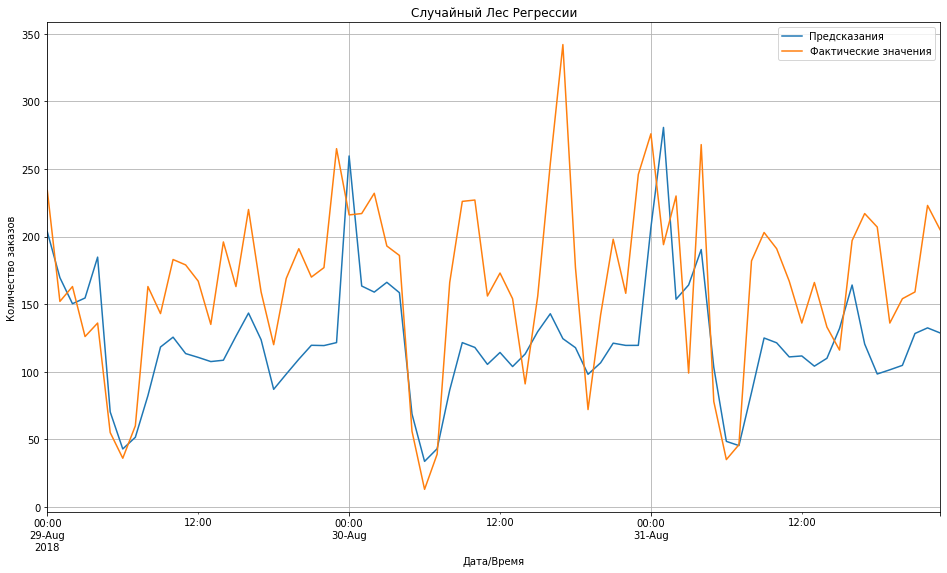

In [49]:
comparison(pred_rfr_test, test_target, '2018-08-29','2018-08-31', "Случайный Лес Регрессии")

**Модель LGBM**

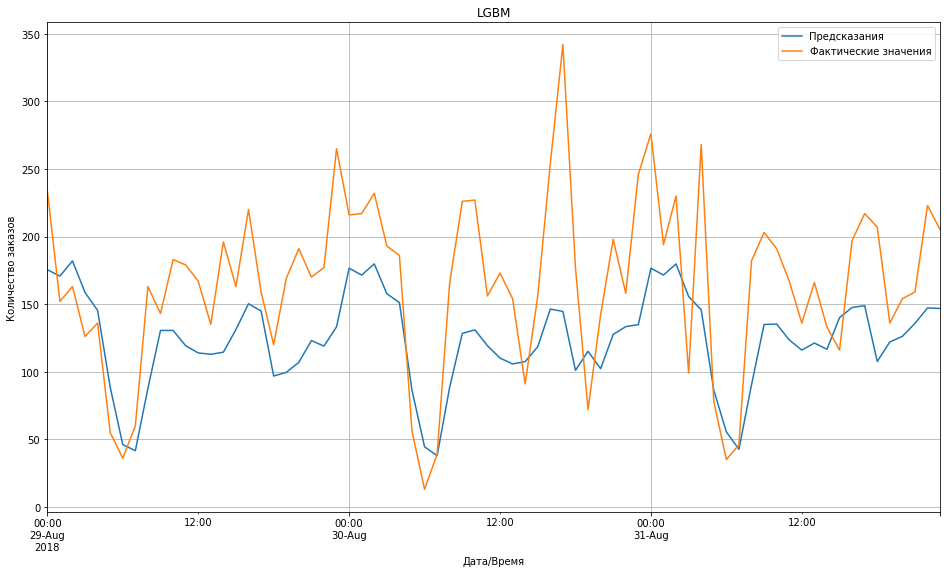

In [50]:
comparison(pred_lgbm_test, test_target, '2018-08-29','2018-08-31', "LGBM")

**Модель CatBoost**

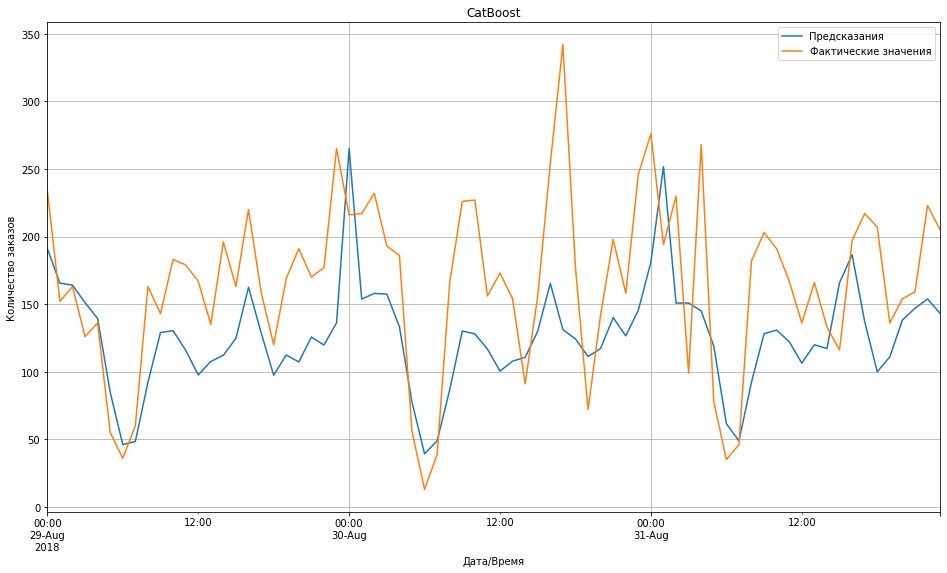

In [51]:
comparison(pred_cat_test, test_target, '2018-08-29','2018-08-31', "CatBoost")

## Вывод

В соответствии с поставленной задачей удалось достигнуть значения целевой метрики RMSE на уровне ниже 48 у трех моделей из четырех. 

Хуже всех по качеству метрики RMSE показала себя модель Линейной регрессии. RMSE = 51.22

***Лучший результат*** у модели CatBoost. RMSE = 42.11